# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
#1
# Imports
import time
import pickle
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import csv
import numpy as np

In [2]:
2
# Load pickled data
training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
#Number of training examples
n_train = len(X_train)

n_validation = len(X_valid)

#Number of testing examples.
n_test = len(X_test)



#What's the shape of an traffic sign image?
image_shape = X_train[0].shape

#How many unique classes/labels there are in the dataset.
n_classes = max(y_train)+1

print("Number of training examples for the test =", n_train)
print("Number of validation examples for the test =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples for the test = 34799
Number of validation examples for the test = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

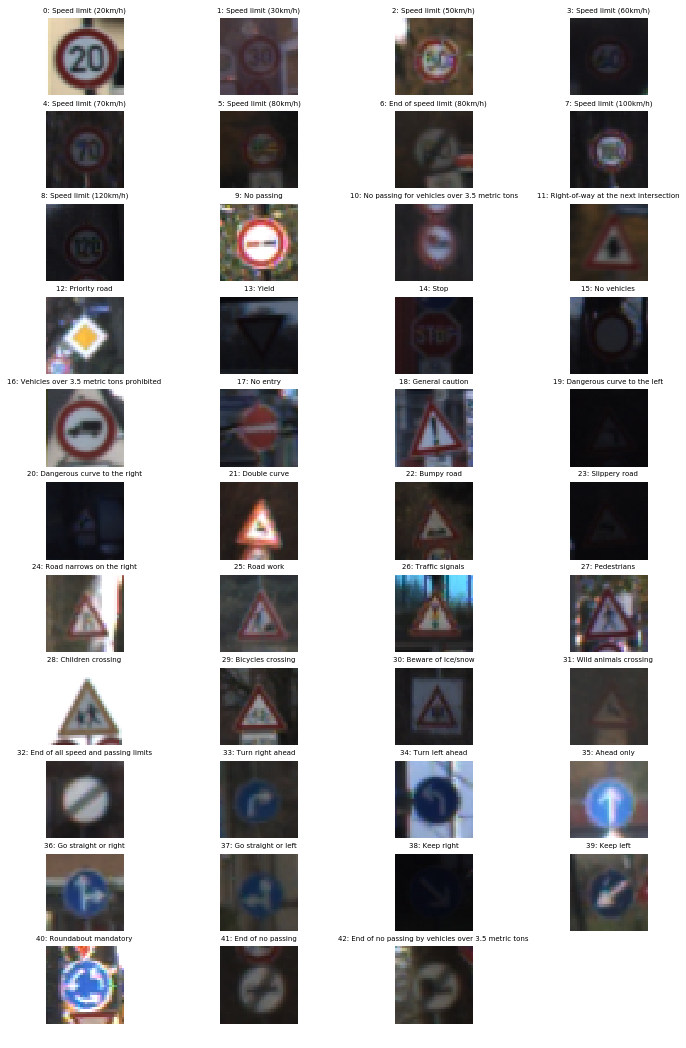

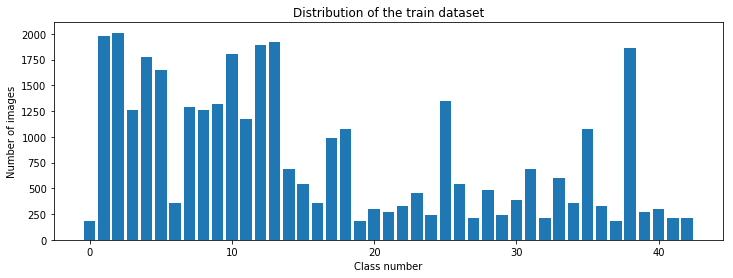

Min number of images per class = 180
Max number of images per class = 2010


In [4]:
#4
#Exploration of the dataset
%matplotlib inline

signnameslist = []
with open('signnames.csv') as csvfile:
    signnames = csv.DictReader(csvfile)
    for row in signnames:
        signnameslist.append(row['SignName'])

num_of_samples=[]
plt.figure(figsize=(12, 18.5))
for i in range(0, n_classes):
    plt.subplot(11, 4, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #first image of each class
    plt.title(str(i) + ": " + signnameslist[i], fontsize=7)
    plt.axis('off')
    num_of_samples.append(len(x_selected))
    
plt.show()

#Plot number of images per class
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

print("Min number of images per class =", min(num_of_samples))
print("Max number of images per class =", max(num_of_samples))

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
#5
import matplotlib as mpl

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

# Normalize between -1.0 and 1.0
def normalize_img(image):
    return cv2.normalize(image, image, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

def normalize_array(arr):
    return np.array([normalize_img(arr[i]) for i in range(len(arr))])
    
#Normalize the Data
X_train = normalize_array(X_train)
X_test = normalize_array(X_test)
X_valid = normalize_array(X_valid)

### Model Architecture

In [6]:
#6
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 14x14x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 48), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(48))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x48. Output = 5x5x48.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x48. Output = 1200.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1200. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1200, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 400. Output = 200.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(200))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 200. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [7]:
#7
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name='x')
y = tf.placeholder(tf.int32, (None), name='y')
one_hot_y = tf.one_hot(y, 43, name='one_hot_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
#8
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
#9
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={
                                                    x: batch_x,
                                                    y: batch_y,
                                                    keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
#10
EPOCHS = 600
BATCH_SIZE = 1024
keep_probability = 0.5

In [11]:
#11
with tf.Session() as sess:
    training_start_time = time.time()
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        start_time = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={
                                            x: batch_x,
                                            y: batch_y,
                                            keep_prob: keep_probability})
        
        end_time = time.time()
        validation_accuracy = evaluate(X_valid, y_valid)
        
        # Print first, last and every 10th
        if((i==0) or ((i+1)%10==0) or ((i+1)==EPOCHS)):
            print('Epoch {}/{} '.format(i+1, EPOCHS),
                  'Validation Accuracy: {:.3f}'.format(validation_accuracy),
                  '{:.4f} sec/batch'.format(end_time-start_time))
                
    saver.save(sess, './lenet')
    training_finish_time = time.time()
    print("Model saved")
    print('Total training time: {:.1f}'.format(training_finish_time-training_start_time))

Training...


ResourceExhaustedError: OOM when allocating tensor with shape[1024,28,28,16]
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_x_0_1/_9, Variable/read)]]

Caused by op 'Conv2D', defined at:
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-39a4ee0ba8ee>", line 4, in <module>
    logits = LeNet(x)
  File "<ipython-input-6-360800060bfb>", line 10, in LeNet
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 397, in conv2d
    data_format=data_format, name=name)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/shashi/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1024,28,28,16]
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_x_0_1/_9, Variable/read)]]


In [ ]:
#12
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

A tip from Slack lead me to this website for German traffic signs:

http://finde-das-bild.de/bildersuche?keys=verkehrsschild

From that site I manually selected the following 5 traffic signs:

http://finde-das-bild.de/bild/schild-vorfahrt

http://finde-das-bild.de/bild/verkehrsschild

http://finde-das-bild.de/bild/verkehrsschild-geschwindigkeit-70

http://finde-das-bild.de/bild/achtung-verengte-fahrbahn-rechts

http://finde-das-bild.de/bild/achtung-ampel-nach-100-meter


I manually searched for signs within the 43 labels already trained for.

Before I loaded the images I used Gimp to manually crop and resize the images to 32x32.
Since all the pictures in the original data already was normalized, I decided to use Gimp to Normalize as well.

# CHECKPOINT
We can continue from here

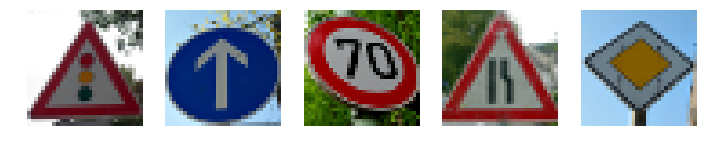

In [14]:
#13
import matplotlib.image as img
image1 = img.imread('external-images/ext1.png')
image2 = img.imread('external-images/ext2.png')
image3 = img.imread('external-images/ext3.png')
image4 = img.imread('external-images/ext4.png')
image5 = img.imread('external-images/ext5.png')

image1_class = 26
image2_class = 35
image3_class = 4
image4_class = 24
image5_class = 12

assert (32,32,3) == image1.shape
assert (32,32,3) == image2.shape
assert (32,32,3) == image3.shape
assert (32,32,3) == image4.shape
assert (32,32,3) == image5.shape

plt.figure(figsize=(12, 18.5))
plt.subplot(1, 5, 1)
plt.imshow(image1)
#plt.title(str(i) + ": " + signnameslist[i], fontsize=7)
plt.axis('off')


plt.subplot(1, 5, 2)
plt.imshow(image2)
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(image3)
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(image4)
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(image5)
plt.axis('off')

plt.show()

### Predict the Sign Type for Each Image

In [15]:
#14
im1=np.array([image1])
im2=np.array([image2])
im3=np.array([image3])
im4=np.array([image4])
im5=np.array([image5])

In [16]:
#15

with tf.Session() as sess:
    # Load the model back into this session
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Run classifications
    temp_res1 = sess.run(logits, feed_dict={x: im1, keep_prob: 1.0})
    temp_res2 = sess.run(logits, feed_dict={x: im2, keep_prob: 1.0})
    temp_res3 = sess.run(logits, feed_dict={x: im3, keep_prob: 1.0})
    temp_res4 = sess.run(logits, feed_dict={x: im4, keep_prob: 1.0})
    temp_res5 = sess.run(logits, feed_dict={x: im5, keep_prob: 1.0})
    res1 = sess.run(tf.nn.top_k(temp_res1, k=1))
    res2 = sess.run(tf.nn.top_k(temp_res2, k=1))
    res3 = sess.run(tf.nn.top_k(temp_res3, k=1))
    res4 = sess.run(tf.nn.top_k(temp_res4, k=1))
    res5 = sess.run(tf.nn.top_k(temp_res5, k=1))

ValueError: Can't load save_path when it is None.

### Analyze Performance

In [22]:
#16
correct = (26,35,4,24,12)

r1 = res1[1][0][0]
r2 = res2[1][0][0]
r3 = res3[1][0][0]
r4 = res4[1][0][0]
r5 = res5[1][0][0]

result = (r1,r2,r3,r4,r5)
assert len(result) == len(correct)

print("Correct: {}".format(correct))
print("Result : {}".format(result))

correct_count=0
for i in range(len(result)):
    if(result[i] == correct[i]):
        correct_count += 1

accuracy = correct_count / len(result) * 100

print("Accuracy: {}%".format(accuracy))

Correct: (26, 35, 4, 24, 12)
Result : (26, 35, 0, 24, 12)
Accuracy: 80.0%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [23]:
#17

# Print most likely classifications
with tf.Session() as sess:
    print("IMAGE1 (Correct(26): {}".format(sess.run(tf.nn.top_k(tf.nn.softmax(temp_res1), k=5))))
    print("IMAGE2 (Correct(35): {}".format(sess.run(tf.nn.top_k(tf.nn.softmax(temp_res2), k=5))))
    print("IMAGE3 (Correct(4): {}".format(sess.run(tf.nn.top_k(tf.nn.softmax(temp_res3), k=5))))
    print("IMAGE4 (Correct(24): {}".format(sess.run(tf.nn.top_k(tf.nn.softmax(temp_res4), k=5))))
    print("IMAGE5 (Correct(12): {}".format(sess.run(tf.nn.top_k(tf.nn.softmax(temp_res5), k=5))))

IMAGE1 (Correct(26): TopKV2(values=array([[  9.99965429e-01,   3.29824325e-05,   7.10148754e-07,
          6.89287731e-07,   8.81627145e-08]], dtype=float32), indices=array([[26, 30, 12, 38, 11]], dtype=int32))
IMAGE2 (Correct(35): TopKV2(values=array([[  1.00000000e+00,   5.92588723e-24,   7.52890552e-29,
          8.07868461e-31,   1.60519613e-33]], dtype=float32), indices=array([[35, 34, 36, 33,  3]], dtype=int32))
IMAGE3 (Correct(4): TopKV2(values=array([[ 0.47062558,  0.09889314,  0.09530148,  0.07172929,  0.07053854]], dtype=float32), indices=array([[ 0, 32, 11, 40, 29]], dtype=int32))
IMAGE4 (Correct(24): TopKV2(values=array([[ 0.48397925,  0.43195409,  0.04340653,  0.00889096,  0.00502721]], dtype=float32), indices=array([[24, 18, 26, 25, 20]], dtype=int32))
IMAGE5 (Correct(12): TopKV2(values=array([[ 1.,  0.,  0.,  0.,  0.]], dtype=float32), indices=array([[12,  0,  1,  2,  3]], dtype=int32))


---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [23]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry



def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
            


### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 